In [1]:
import numpy as np
import matplotlib.pyplot as plt

def _r2(y, yhat):
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # if the block is flat (ss_tot == 0), R^2 is undefined; return nan
    return 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")

def _split_into_blocks(steps, idxs, block_size, idx_start=64):
    """
    Assign each point to a block id based on idx.
    block_id = floor((idx - idx_start) / block_size)
    """
    block_ids = ((idxs - idx_start) // block_size).astype(np.int64)
    # group indices by block id
    blocks = {}
    for i, bid in enumerate(block_ids):
        blocks.setdefault(int(bid), []).append(i)
    return blocks

def plot_step_idx_within_block_r2(
    series_list,
    labels=None,
    block_size=64,
    idx_start=64,
    xlim=(0, 127),
    ylim=(64, 191),
    title="step vs idx (within-block linearity)",
    show_block_fits=False,  # set True if you also want dashed fit lines per block
):
    """
    series_list: list of dict-lists, each dict has {"step": ..., "idx": ...}
    block_size: block length in idx space (e.g., 64)
    idx_start: starting idx of the first block (you said 64)
    """

    if labels is None:
        labels = [f"series_{i}" for i in range(len(series_list))]

    plt.figure(figsize=(10, 5))

    for series, name in zip(series_list, labels):
        steps = np.array([d["step"] for d in series], dtype=np.int64)
        idxs  = np.array([d["idx"]  for d in series], dtype=np.float64)

        # sort by step for nicer curves
        order = np.argsort(steps)
        steps = steps[order]
        idxs  = idxs[order]

        # plot the raw curve
        plt.plot(steps, idxs, linewidth=2, label=name)

        # split into idx-based blocks
        blocks = _split_into_blocks(steps, idxs, block_size=block_size, idx_start=idx_start)

        # per-block stats + aggregated "within-block" R^2
        per_block = []
        total_ss_res = 0.0
        total_ss_tot = 0.0

        for bid in sorted(blocks.keys()):
            idx_list = blocks[bid]
            s = steps[idx_list].astype(np.float64)
            y = idxs[idx_list].astype(np.float64)

            # Need at least 2 points and non-constant x to fit a line
            if len(s) < 2 or np.ptp(s) == 0:
                per_block.append((bid, float("nan"), float("nan"), float("nan")))
                continue

            m, b = np.polyfit(s, y, deg=1)
            yhat = m * s + b
            r2 = _r2(y, yhat)
            per_block.append((bid, m, b, r2))

            # aggregate SSE/SST across blocks (so block jumps don't help)
            ss_res = np.sum((y - yhat) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            total_ss_res += ss_res
            total_ss_tot += ss_tot

            if show_block_fits:
                # draw fitted line only over the steps present in this block
                smin, smax = s.min(), s.max()
                ss = np.array([smin, smax])
                plt.plot(ss, m * ss + b, linestyle="--", linewidth=1)

        overall_within_r2 = 1.0 - (total_ss_res / total_ss_tot) if total_ss_tot > 0 else float("nan")

        # print results
        print(f"\n{name}: within-block overall R^2 = {overall_within_r2:.6f}  (block_size={block_size}, idx_start={idx_start})")
        for bid, m, b, r2 in per_block:
            print(f"  block {bid:>2}: slope={m:.6f} intercept={b:.3f} R^2={r2:.6f}")

    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel("step")
    plt.ylabel("idx")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [2]:
import os
from datasets import Dataset
from collections import defaultdict

folder_base = 'kv_states_20260219'
dict_line_logs = defaultdict(list)

for name_file in os.listdir(folder_base):
    if name_file[0] == '.':
        continue
    # end

    path_file = os.path.join(folder_base, name_file)
    ds = Dataset.load_from_disk(path_file)

    for step, item in enumerate(list(ds['idx_token'])):
        dict_log = {}
        dict_log['step'] = step
        dict_log['idx'] = item[0]
        dict_line_logs[name_file.split('.')[0]].append(dict_log)
    # end
# end

/home/exx/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
list_lines_illustrate_32 = [dict_line_logs[key] for key in dict_line_logs.keys() if key.split('-')[-1] == '32']
list_lines_illustrate_64 = [dict_line_logs[key] for key in dict_line_logs.keys() if key.split('-')[-1] == '64']
list_lines_illustrate_128 = [dict_line_logs[key] for key in dict_line_logs.keys() if key.split('-')[-1] == '128']


series_0: within-block overall R^2 = 0.081323  (block_size=64, idx_start=64)
  block  0: slope=-0.374725 intercept=107.304 R^2=0.140419
  block  1: slope=0.149084 intercept=145.262 R^2=0.022226

series_1: within-block overall R^2 = 0.187473  (block_size=64, idx_start=64)
  block  0: slope=0.108150 intercept=92.093 R^2=0.011696
  block  1: slope=0.602701 intercept=101.942 R^2=0.363249

series_2: within-block overall R^2 = 0.304648  (block_size=64, idx_start=64)
  block  0: slope=0.778388 intercept=70.981 R^2=0.605888
  block  1: slope=0.058379 intercept=153.925 R^2=0.003408

series_3: within-block overall R^2 = 0.041394  (block_size=64, idx_start=64)
  block  0: slope=0.198168 intercept=89.258 R^2=0.039271
  block  1: slope=0.208608 intercept=139.578 R^2=0.043517

series_4: within-block overall R^2 = 0.313344  (block_size=64, idx_start=64)
  block  0: slope=0.733745 intercept=72.387 R^2=0.538382
  block  1: slope=0.297161 intercept=131.121 R^2=0.088305

series_5: within-block overall R

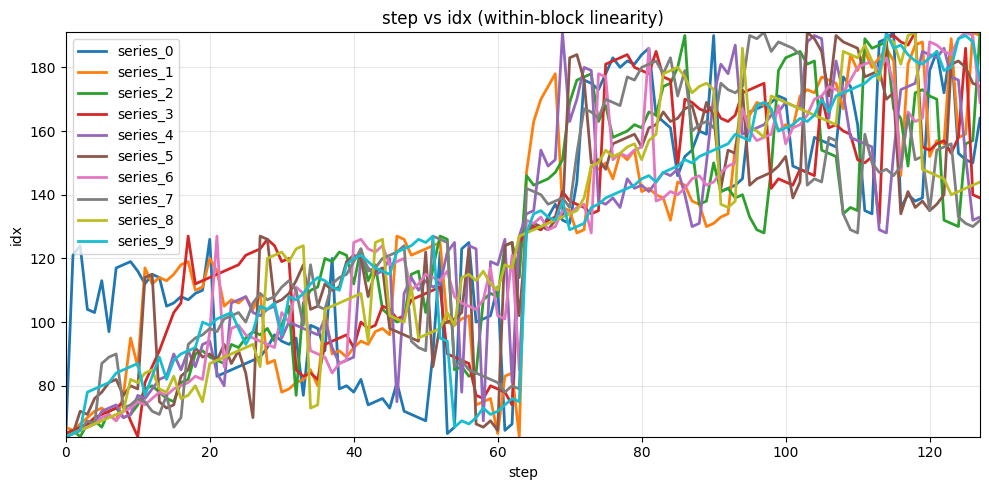

In [ ]:

# ------------------ Example usage ------------------

plot_step_idx_within_block_r2(
    list_lines_illustrate_128,
    block_size=128,   # your setting
    idx_start=64,
    show_block_fits=False,
)
